# Preprocess Road Network

- Query from Ohsome API
- Explore road network
- Preprocess road network
- Save road network as feather file

In [1]:
import sys
import yaml
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from ohsome import OhsomeClient
from shapely.geometry import LineString, MultiLineString

sns.set_theme(style="ticks")
sns.set_context("paper")

datetime = '2024-03-15T00:00:00Z'

data_dir = Path('../data')
out_dir = Path('../outdir')

## Area of Interest

In [2]:
aoi_gdf = gpd.read_file(data_dir / 'MA-HD-RNK.geojson')
aoi_bpoly = aoi_gdf.to_json()

## Road Network

### Query road network with Ohsome

In [3]:
client = OhsomeClient()

responses = []
try:
    response = client.elements.geometry.post(
        bpolys = aoi_bpoly, 
        filter = 'highway=* and type:way and geometry:line',
        time = datetime,
        properties = 'tags'
    )
    road_network_gdf = response.as_dataframe()
except Exception as err:
    print(f'Could not send request to ohsome API: {err}')
    sys.exit()

### Explore road network

In [4]:
len(road_network_gdf)

141586

Calculate road lengths

In [16]:
road_network_gdf_len = road_network_gdf.copy()
road_network_gdf_len.to_crs(epsg=25832, inplace=True)
road_network_gdf_len['road_length'] = round(road_network_gdf_len['geometry'].length, 2)
f'{round(road_network_gdf_len["road_length"].sum() / 1000, 2)} km'

'17836.11 km'

Check for any lists in the road network

In [17]:
any(road_network_gdf.map(lambda x: isinstance(x, list)).any())

False

Check geometry types

In [18]:
road_network_gdf['geometry'].apply(lambda geom: type(geom).__name__).value_counts()

/home/grhalbgott/miniforge3/envs/lulc-ma/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


LineString         141486
MultiLineString        96
Point                   4
Name: count, dtype: int64

Check unique highway tags

In [19]:
road_network_gdf['highway'].value_counts().sort_values(ascending=False)

highway
service           29207
footway           27441
track             23176
residential       18074
path              15906
steps              5025
secondary          4813
tertiary           4372
primary            3053
living_street      2610
unclassified       2530
cycleway            893
motorway            792
primary_link        617
motorway_link       583
secondary_link      549
trunk               463
pedestrian          457
trunk_link          388
bridleway           141
construction        126
tertiary_link       115
corridor             73
proposed             52
platform             47
raceway              46
bus_stop             15
busway               12
street_lamp           4
via_ferrata           4
elevator              1
razed                 1
Name: count, dtype: int64

### Preprocess road network

In [5]:
preprocessed_road_network = road_network_gdf.copy()

Remove polygons and Points

In [6]:
preprocessed_road_network = preprocessed_road_network[preprocessed_road_network['geometry'].apply(lambda geom: isinstance(geom, (LineString, MultiLineString)))]
len(preprocessed_road_network)

/home/grhalbgott/miniforge3/envs/lulc-ma/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


141582

In [2]:
preprocessed_road_network = gpd.read_feather(out_dir / 'preprocessed_road_network.feather')

<Figure size 1000x1000 with 0 Axes>

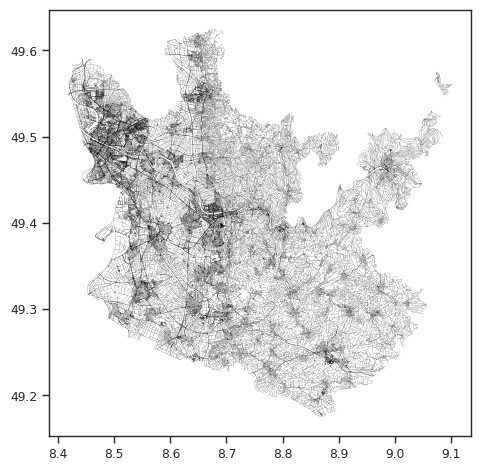

In [4]:
plt.figure(figsize=(25, 25))

preprocessed_road_network.plot(color='black', linewidth=0.1)

# plt.savefig(out_dir / 'road_network.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

Remove unneeded columns

In [8]:
with open(data_dir / 'road_network_asset.yaml', 'r') as src:
    tags_list = yaml.safe_load(src)['tags']
tags = [tag.strip() for tag in tags_list]
tags_to_keep = [col for col in tags if col in preprocessed_road_network.columns]

In [9]:
preprocessed_road_network = preprocessed_road_network[tags_to_keep]
len(preprocessed_road_network)

141582

Remove unneeded highway types

In [10]:
with open(data_dir / 'road_network_asset.yaml', 'r') as src:
    road_types_list = yaml.safe_load(src)['road_types']

In [11]:
preprocessed_road_network = preprocessed_road_network[preprocessed_road_network['highway'].isin(road_types_list)]

### Verifying preprocessed road network

<Figure size 1000x1000 with 0 Axes>

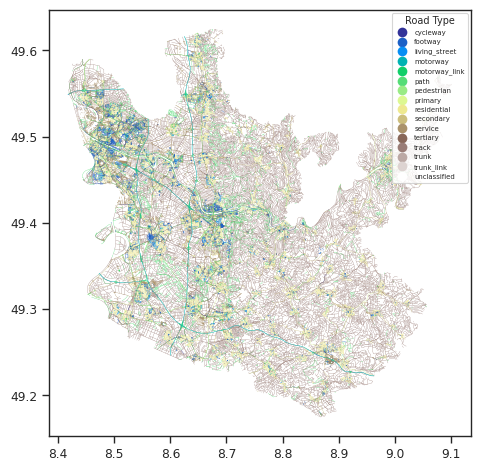

In [4]:
plt.figure(figsize=(25, 25))

preprocessed_road_network.plot(
    column='highway', 
    cmap='terrain', 
    linewidth=0.2, 
    legend=True, 
    legend_kwds={'loc': 'upper right', 'title': 'Road Type', 'title_fontsize': 7, 'fontsize': 5, 'markerscale': 0.7}
)

# plt.savefig(out_dir / 'road_network_types.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [ ]:
preprocessed_road_network['highway'].value_counts().sort_values(ascending=False)

highway
service          29207
footway          27441
track            23176
residential      18074
path             15905
secondary         4812
tertiary          4370
primary           3053
living_street     2610
unclassified      2530
cycleway           893
motorway           792
motorway_link      583
trunk              463
pedestrian         457
trunk_link         388
Name: count, dtype: int64

### Export road network as feather file

In [ ]:
preprocessed_road_network.to_feather(out_dir / 'preprocessed_road_network.feather')

In [11]:
roads = gpd.read_feather(out_dir / 'preprocessed_road_network.feather')

In [12]:
roads = roads[['highway', 'geometry']]

In [14]:
for rt in roads['highway'].unique():
    road_ex = roads[roads['highway'] == rt]
    road_ex.to_file(out_dir / 'road_types' / f'{rt}.geojson', driver='GeoJSON')